In [3]:
import numpy as np

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import Aer
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_nature.units import DistanceUnit
from qiskit_nature import settings

from scipy.optimize import minimize

import matplotlib.pyplot as plt

from qiskit_ibm_runtime import Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator

In [4]:
backend = Aer.get_backend("qasm_simulator")

In [13]:
settings.use_pauli_sum_op = False

driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.735",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

electronic_structure = driver.run()

hamiltonian = electronic_structure.hamiltonian.second_q_op()

# mapper = JordanWignerMapper()
mapper = ParityMapper(num_particles=electronic_structure.num_particles)
tapered_mapper = electronic_structure.get_tapered_mapper(mapper)

# qubit_op = mapper.map(hamiltonian)
tapered_op = tapered_mapper.map(hamiltonian)

hamiltonian_list = []

for pauli, coeff in sorted(tapered_op.label_iter()):
    # print(f"{coeff.real:+.8f} * {pauli}")
    hamiltonian_list.append((pauli, coeff.real))
    
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)
print(hamiltonian)

SparsePauliOp(['I', 'X', 'Z'],
              coeffs=[-1.04109314+0.j, -0.1809312 +0.j, -0.79587485+0.j])


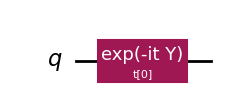

In [14]:
ansatz = UCCSD(
        electronic_structure.num_spatial_orbitals,
        electronic_structure.num_particles,
        tapered_mapper,
        initial_state=HartreeFock(
            electronic_structure.num_spatial_orbitals,
            electronic_structure.num_particles,
            tapered_mapper,
        ),
    )
num_params = ansatz.num_parameters

ansatz.decompose().draw("mpl")

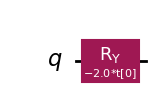

In [15]:
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = pm.run(ansatz)

hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

ansatz_isa.draw(output="mpl")

In [16]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0] + nuclear_repulsion_energy

    cost_history["iters"] += 1
    cost_history["prev_vector"] = params
    cost_history["cost_history"].append(energy)
    print(f"Iters. done: {cost_history['iters']} [Current cost: {energy}]")

    return energy

cost_history = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

nuclear_repulsion_energy = electronic_structure.nuclear_repulsion_energy

In [17]:
# x0 = 2 * np.pi * np.random.random(num_params)
x0 = np.zeros(num_params)
x0

array([0.])

In [18]:
with Session(backend=backend) as session:
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 10000

    result = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, hamiltonian_isa, estimator),
        method="cobyla",
    )

Iters. done: 1 [Current cost: -1.1148787092565313]
Iters. done: 2 [Current cost: 0.17417093217118096]
Iters. done: 3 [Current cost: -0.1512942847715687]
Iters. done: 4 [Current cost: -0.8918064567548222]
Iters. done: 5 [Current cost: -0.9242068195780092]
Iters. done: 6 [Current cost: -1.1431551826676585]
Iters. done: 7 [Current cost: -1.0973798890288466]
Iters. done: 8 [Current cost: -1.1295944657632346]
Iters. done: 9 [Current cost: -1.1399021202259512]
Iters. done: 10 [Current cost: -1.1298193848195877]
Iters. done: 11 [Current cost: -1.1349401546958369]
Iters. done: 12 [Current cost: -1.140064725855166]
Iters. done: 13 [Current cost: -1.1408760908240527]
Iters. done: 14 [Current cost: -1.1311944220583916]
Iters. done: 15 [Current cost: -1.1443914740007433]
Iters. done: 16 [Current cost: -1.1418300029817385]
Iters. done: 17 [Current cost: -1.138808919122106]
Iters. done: 18 [Current cost: -1.1361227871929565]
Iters. done: 19 [Current cost: -1.1297646399027426]


In [19]:
result

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.1297646399027426
       x: [-1.244e-01]
    nfev: 19
   maxcv: 0.0

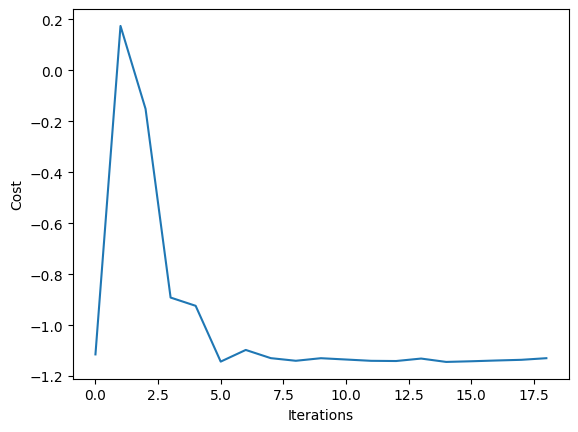

In [20]:
fig, ax = plt.subplots()
ax.plot(range(cost_history["iters"]), cost_history["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()